In [55]:
# Probabilistic rain event forecaster – Montreal

# Simple project: predict the probability that it will rain tomorrow in Montreal using historical daily weather from Open-Meteo and a logistic regression model.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
print("pandas version:", pd.__version__)

pandas version: 2.3.3


In [57]:
import requests
from pathlib import Path

# 1) Location and time window dataset
latitude = 45.5088   # Montreal 
longitude = -73.5878
start_date = "2018-01-01"
end_date = "2024-12-31"   

# 2) Project folder structure for raw data
data_dir = Path("data")
raw_dir = data_dir / "raw"
raw_dir.mkdir(parents=True, exist_ok=True)

output_csv = raw_dir / "montreal_daily_weather.csv"

output_csv

PosixPath('data/raw/montreal_daily_weather.csv')

In [58]:
# 1. Download daily Montreal weather via Open-Meteo API

In [59]:
import requests
import pandas as pd
from pathlib import Path

# 1) Paste the long URL from the docs here (keep the quotes)
url = "https://archive-api.open-meteo.com/v1/archive?latitude=45.5088&longitude=-73.5878&start_date=2018-01-01&end_date=2024-12-31&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max,temperature_2m_mean,relative_humidity_2m_mean,cloud_cover_mean,pressure_msl_mean,wind_speed_10m_min&timezone=America%2FNew_York"

# 2) Call the API
response = requests.get(url)
print("Status code:", response.status_code)
print("First 200 chars of URL:", response.url[:200])

# If status is not 200, this will throw and show you the server's message
response.raise_for_status()

data = response.json()
print("Top-level keys:", data.keys())
print("Daily keys:", data["daily"].keys())

Status code: 200
First 200 chars of URL: https://archive-api.open-meteo.com/v1/archive?latitude=45.5088&longitude=-73.5878&start_date=2018-01-01&end_date=2024-12-31&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowf
Top-level keys: dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'daily_units', 'daily'])
Daily keys: dict_keys(['time', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'temperature_2m_mean', 'relative_humidity_2m_mean', 'cloud_cover_mean', 'pressure_msl_mean', 'wind_speed_10m_min'])


In [60]:
# 2. Build daily DataFrame

In [61]:
daily = data["daily"]            # dict of lists
df_weather = pd.DataFrame(daily)

# Make 'time' a datetime index for time-series work
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather = df_weather.set_index("time").sort_index()

print(df_weather.shape)
df_weather.head()

(2557, 12)


,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max,temperature_2m_mean,relative_humidity_2m_mean,cloud_cover_mean,pressure_msl_mean,wind_speed_10m_min
time,,,,,,,,,,,,
2018-01-01,-22.0,-26.8,0.0,0.0,0.00,18.6,35.6,-24.8,72,19,1027.9,7.2
2018-01-02,-16.2,-29.3,1.9,0.0,1.33,12.0,23.0,-22.5,77,88,1022.6,1.1
2018-01-03,-7.9,-18.7,0.9,0.0,0.63,15.9,29.2,-13.0,78,96,1019.2,1.6
2018-01-04,-8.8,-12.9,2.2,0.0,1.54,24.7,46.4,-10.7,77,100,1007.8,6.9
2018-01-05,-11.5,-22.6,4.7,0.1,3.29,31.3,59.8,-19.5,64,100,1002.6,22.8


In [62]:
# Base dir = project root, one level above notebooks/
BASE_DIR = Path("..")
RAW_DIR = BASE_DIR / "data" / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

out_path = RAW_DIR / "montreal_daily_2018_2024.csv"
df_weather.to_csv(out_path)

print("Saved to:", out_path.resolve())

Saved to: /Users/yiyang/Desktop/Probabilistic-rain-event-forecaster/data/raw/montreal_daily_2018_2024.csv


In [63]:
df_check = pd.read_csv(out_path, parse_dates=["time"]).set_index("time")
print(df_check.shape)
df_check.head()

(2557, 12)


,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max,temperature_2m_mean,relative_humidity_2m_mean,cloud_cover_mean,pressure_msl_mean,wind_speed_10m_min
time,,,,,,,,,,,,
2018-01-01,-22.0,-26.8,0.0,0.0,0.00,18.6,35.6,-24.8,72,19,1027.9,7.2
2018-01-02,-16.2,-29.3,1.9,0.0,1.33,12.0,23.0,-22.5,77,88,1022.6,1.1
2018-01-03,-7.9,-18.7,0.9,0.0,0.63,15.9,29.2,-13.0,78,96,1019.2,1.6
2018-01-04,-8.8,-12.9,2.2,0.0,1.54,24.7,46.4,-10.7,77,100,1007.8,6.9
2018-01-05,-11.5,-22.6,4.7,0.1,3.29,31.3,59.8,-19.5,64,100,1002.6,22.8


In [64]:
# 3. Create labels (rain_today, rain_tomorrow)

In [65]:
import numpy as np

df = df_check.copy()

# threshold in mm
RAIN_THRESHOLD = 0.5

# Binary flag for rain today
df["rain_today"] = (df["rain_sum"] > RAIN_THRESHOLD).astype(int)

# Binary flag for rain tomorrow: shift rain_sum one day backwards
df["rain_tomorrow"] = (df["rain_sum"].shift(-1) > RAIN_THRESHOLD).astype(int)

# Drop the last row (
df = df.iloc[:-1]

df[["rain_sum", "rain_today", "rain_tomorrow"]].head(10)

,rain_sum,rain_today,rain_tomorrow
time,,,
2018-01-01,0.0,0,0
2018-01-02,0.0,0,0
2018-01-03,0.0,0,0
2018-01-04,0.0,0,0
2018-01-05,0.1,0,0
2018-01-06,0.0,0,0
2018-01-07,0.0,0,0
2018-01-08,0.0,0,0
2018-01-09,0.0,0,0


In [66]:
print("Proportion of rainy tomorrows:", df["rain_tomorrow"].mean())
print(df["rain_tomorrow"].value_counts())

Proportion of rainy tomorrows: 0.3364632237871675
rain_tomorrow
0    1696
1     860
Name: count, dtype: int64


In [67]:
# 4. Train/test split

In [68]:
import numpy as np
import pandas as pd

print(df.columns)

FEATURES = [
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "rain_sum",
    "snowfall_sum",
    "wind_speed_10m_max",
    "wind_gusts_10m_max",
]

TARGET = "rain_tomorrow"

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("X shape:", X.shape)
print("y mean (rain frequency):", y.mean())
X.head()

Index(['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
       'temperature_2m_mean', 'relative_humidity_2m_mean', 'cloud_cover_mean',
       'pressure_msl_mean', 'wind_speed_10m_min', 'rain_today',
       'rain_tomorrow'],
      dtype='object')
X shape: (2556, 7)
y mean (rain frequency): 0.3364632237871675


,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max
time,,,,,,,
2018-01-01,-22.0,-26.8,0.0,0.0,0.00,18.6,35.6
2018-01-02,-16.2,-29.3,1.9,0.0,1.33,12.0,23.0
2018-01-03,-7.9,-18.7,0.9,0.0,0.63,15.9,29.2
2018-01-04,-8.8,-12.9,2.2,0.0,1.54,24.7,46.4
2018-01-05,-11.5,-22.6,4.7,0.1,3.29,31.3,59.8


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, #20%     
    random_state=42,   
    stratify=y         
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train rain freq:", y_train.mean())
print("Test rain freq:", y_test.mean())

Train size: 2044
Test size: 512
Train rain freq: 0.33659491193737767
Test rain freq: 0.3359375


In [70]:
# 5. Logistic regression model

In [71]:
from sklearn.linear_model import LogisticRegression

# Logistic regression: 
# linear model + sigmoid => probability of rain
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"  
)

clf.fit(X_train, y_train)

print("Fitted coefficients:")
for name, coef in zip(FEATURES, clf.coef_[0]):
    print(f"{name:25s} {coef: .3f}")

print("Intercept:", clf.intercept_[0])

Fitted coefficients:
temperature_2m_max         0.046
temperature_2m_min         0.005
precipitation_sum          0.013
rain_sum                   0.054
snowfall_sum              -0.041
wind_speed_10m_max         0.053
wind_gusts_10m_max        -0.042
Intercept: -0.13347729977992423


In [72]:
# 6. Evaluation & ROC curve

In [73]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# 0/1 predictions and probability predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Model accuracy: {accuracy:.3f}")
print(f"ROC AUC:       {roc_auc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Baseline: always guess the majority class (probably 'no rain')
baseline_acc = max(y_test.mean(), 1 - y_test.mean())
print(f"\nBaseline accuracy (always majority class): {baseline_acc:.3f}")

Model accuracy: 0.586
ROC AUC:       0.664
Confusion matrix (rows=true, cols=pred):
 [[195 145]
 [ 67 105]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.57      0.65       340
           1       0.42      0.61      0.50       172

    accuracy                           0.59       512
   macro avg       0.58      0.59      0.57       512
weighted avg       0.64      0.59      0.60       512


Baseline accuracy (always majority class): 0.664


In [74]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

thresholds = np.linspace(0.05, 0.95, 19)

results = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    f1  = f1_score(y_test, y_pred_t)
    results.append((t, acc, f1))

best_acc_t, best_acc, best_acc_f1 = max(results, key=lambda x: x[1])
best_f1_t, best_f1_acc, best_f1 = max(results, key=lambda x: x[2])

print("Best accuracy:")
print(f"  threshold={best_acc_t:.2f}, accuracy={best_acc:.3f}, F1={best_acc_f1:.3f}")
print("\nBest F1:")
print(f"  threshold={best_f1_t:.2f}, accuracy={best_f1_acc:.3f}, F1={best_f1:.3f}")

print(f"\nBaseline accuracy (always majority class): {baseline_acc:.3f}")

Best accuracy:
  threshold=0.70, accuracy=0.682, F1=0.227

Best F1:
  threshold=0.35, accuracy=0.525, F1=0.559

Baseline accuracy (always majority class): 0.664


In [75]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

BEST_T = 0.35  # from the Best F1 line

y_pred_best = (y_proba >= BEST_T).astype(int)

print(f"Using threshold={BEST_T:.2f}")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification report:\n", classification_report(y_test, y_pred_best))

Using threshold=0.35
Accuracy: 0.525390625
F1: 0.558983666061706
Confusion matrix (rows=true, cols=pred):
 [[115 225]
 [ 18 154]]

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.34      0.49       340
           1       0.41      0.90      0.56       172

    accuracy                           0.53       512
   macro avg       0.64      0.62      0.52       512
weighted avg       0.71      0.53      0.51       512



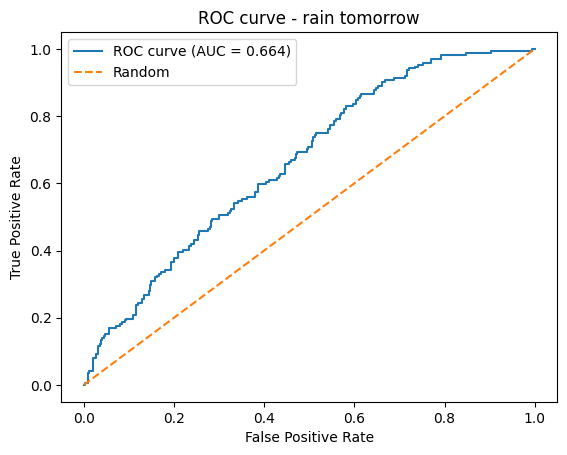

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - rain tomorrow")
plt.legend()
plt.show()

In [77]:
# 7. Helper: predict_rain_prob()

In [79]:
FEATURES = X_train.columns.tolist()

def predict_rain_prob(today_features: dict):
    """
    Predict probability of rain tomorrow given today's features.

    today_features: dict with keys matching FEATURES, e.g.
      {
        "rain_sum": 1.2,
        "snowfall_sum": 0.0,
        "temperature_2m_max": -3.0,
        "temperature_2m_min": -10.0,
        "wind_speed_10m_max": 25.0,
        ...
      }
    """
    x = pd.DataFrame([today_features])[FEATURES]
    p = clf.predict_proba(x)[0, 1]
    y_hat = int(p >= BEST_T)
    return p, y_hat

# Demo from an actual day in the test set:
example = X_test.iloc[0].to_dict()
p, y_hat = predict_rain_prob(example)
print("Example day from test set")
print("Prob rain tomorrow:", p)
print("Predicted label:", y_hat)
print("True label:", y_test.iloc[0])

Example day from test set
Prob rain tomorrow: 0.26448117456294085
Predicted label: 0
True label: 0


In [81]:
today = {
    "rain_sum": 1.0,
    "snowfall_sum": 0.0,
    "precipitation_sum": 1.0,    
    "temperature_2m_max": 3.0,
    "temperature_2m_min": -2.0,
    "temperature_2m_mean": 0.5,
    "wind_speed_10m_max": 20.0,
    "wind_gusts_10m_max": 35.0,
}
p, label = predict_rain_prob(today)
print(f"Probability of rain tomorrow: {p:.2%}")
print("Prediction:", "rain" if label == 1 else "no rain")

Probability of rain tomorrow: 41.08%
Prediction: rain
